In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


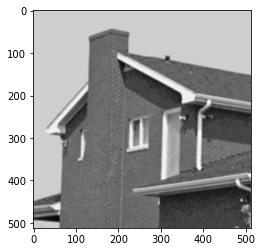

In [3]:
c= imread('house.png')
c = c[:,:,0]
imshow(c)
gray()
c_old = c.copy()

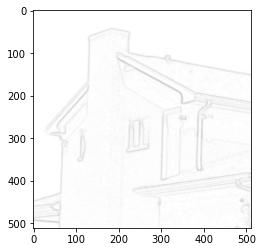

In [4]:
imshow(1 - sqrt((diff(c,n=1,axis=0)[:,:-1])**2+(diff(c,n=1,axis=1)[:-1,:])**2),vmin =0, vmax = 1)

In [5]:
def uxxyy(u, dx=1, dy=1):
    
    dx2 = dx ** 2
    dy2 = dy ** 2
    
    uxx = zeros_like(u)
    uyy = zeros_like(u)
    
    uxx[:, 1:-1] = (u[:, 2:] -2*u [:, 1:-1] + u[:, :-2]) / (dx2)
    uxx[:, 0] = (u[:, 0] - 2*u[:, 1] + u[:, 2]) / dx2
    uxx[:, -1] = (u[:, -1] - 2*u[:, -2] + u[:, -3]) / dx2
        
    uyy[1:-1, :] = (u[2:, :] -2*u [1:-1, :] + u[:-2, :]) / (dy2)
    uyy[0, :] = (u[0, :] - 2*u[1, :] + u[2, :]) / dy2
    uyy[-1, :] = (u[-1, :] - 2*u[-2, :] + u[-3, :])
    
    return (uxx, uyy)

def Laplacian(u, dx=1, dy=1):
    lap = uxxyy(u, dx, dy)
    return lap[0] + lap[1]
    
def diff_tensor(x, y, alpha):
    return 1 / sqrt(1 + (x**2 + y**2)/alpha**2)

def grad_O1(u, dx=1, dy=1):
    ux = zeros_like(u)
    uy = zeros_like(u)
    
    ux[:, :-1] = (u[:, 1:] - u[:, :-1])/ dx
    ux[:, -1] = (u[:, -1] - u[:, -2]) / dx
    
    uy[:-1, :] = (u[1:, :] - u[:-1, :])/ dy
    uy[-1, :] = (u[-1, :] - u[-2, :]) / dy
    
    return (ux, uy)

def grad(u, dx=1, dy=1):
    ux = zeros_like(u)
    uy = zeros_like(u)
    
    ux[:, 1:-1] = (u[:, 2:] - u[:, :-2])/ (2*dx)
    ux[:, 0] = (-3*u[:, 0] + 4*u[:, 1] - u[:, 2]) / (2*dx)
    ux[:, -1] = (3*u[:, -1] - 4*u[:, -2] + u[:, -3]) / (2*dx)
    
    uy[1:-1, :] = (u[2:, :] - u[:-2, :])/ (2*dy)
    uy[0, :] = (-3*u[0, :] + 4*u[1, :] - u[2, :]) / (2*dy)
    uy[-1, :] = (3*u[-1, :] - 4*u[-2, :] + u[-3, :]) / (2*dy)
    
    return (ux, uy)

def div(ux, uy, dx=1, dy=1):
    uxx = zeros_like(ux)
    uyy = zeros_like(uy)
    
    uxx[:, 1:-1] = (ux[:, 2:] - ux[:, :-2])/ (2*dx)
    uxx[:, 0] = (-3*ux[:, 0] + 4*ux[:, 1] - ux[:, 2]) / (2*dx)
    uxx[:, -1] = (3*ux[:, -1] - 4*ux[:, -2] + ux[:, -3]) / (2*dx)
    
    uyy[1:-1, :] = (uy[2:, :] - uy[:-2, :])/ (2*dy)
    uyy[0, :] = (-3*uy[0, :] + 4*uy[1, :] - uy[2, :]) / (2*dy)
    uyy[-1, :] = (3*uy[-1, :] - 4*uy[-2, :] + uy[-3, :]) / (2*dy)
    
    return uxx + uyy

def div_2(gradu, dx=1, dy=1):
    return div(gradu[0], gradu[1], dx, dy)

def div_grad(u, m):
    M, N = u.shape
    
    ux = zeros((M,N))
    uy = zeros((M,N))
    
    ux[:, :-1] = u[:, 1:] - u[:, :-1]
    ux[:, -1] = u[:, -1] - u[:, -2]
    
    uy[:-1, :] = u[1:, :] - u[:-1, :]
    uy[-1, :] = u[-1, :] - u[-2, :]
    
    ux = m*ux
    uy = m*uy
    
    uxx = zeros((M,N))
    uyy = zeros((M,N))
    
    uxx[:, 1:] = ux[:, 1:] - ux[:, :-1]
    uxx[:, 0] = ux[:, 1] - ux[:, 0]
    
    uyy[1:, :] = uy[1:, :] - uy[:-1, :]
    uyy[0, :] = uy[1, :] - uy[0, :]
    
    return uxx+uyy
    

def inhomold(u0, alpha, dt, Nt, dx=1, dy=1):
    grad_f = grad(u0, dy, dx)

    m = diff_tensor(grad_f[0], grad_f[1], alpha)
    Nt = int(Nt)

    u=u0
    k=0
    while k < Nt:
        update = div_2(m*grad(u, dx, dy))
        u += dt * update
        k+=1

    return u

def inhomold2(u0, alpha, dt, Nt, dx=1, dy=1):
    grad_f = gradient(u0)

    m = diff_tensor(grad_f[0], grad_f[1], alpha)
    Nt = int(Nt)

    u=u0
    k=0
    while k < Nt:
        grad_u = gradient(u)
        update = div_2([m*grad_u[0],m*grad_u[1]])
        u += dt * update
        k+=1

    return u
    
def heateqn2d(alpha, dx, dy, dt, M, N, t_max, u0):
    #M is maximum xvalue and N is maximum y value

    #calculate largest possible value of dt for stability

    Nt= int( ( t_max / dt ) + 1)

    #calculate initial timestep
    u = u0.copy()

    #calculate other timesteps

    for k in range(0, Nt - 1):
        uxx, uyy = uxxyy(u)
        u = u + (alpha * dt) * (uxx + uyy)

    return u

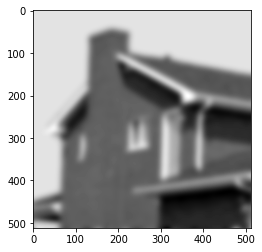

In [8]:
imshow(heateqn2d(0.1, dx=1, dy=1, dt=0.1, M=c.shape[0], N = c.shape[1], t_max = 250, u0=c))

In [9]:
def inhomold_2pt(u0, alpha, dt, Nt, dx=1, dy=1):
    grad_f = grad_O1(u0, dy, dx)

    m = diff_tensor(grad_f[0], grad_f[1], alpha)
    Nt = int(Nt)

    u=u0
    k=0
    while k < Nt:
        u += dt * div_grad(u,m)
        k+=1

    return u

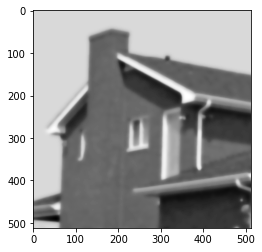

In [10]:
imshow(inhomold_2pt(c.copy(), .05, dt=0.01, Nt = 1000, dx=1, dy=1))

In [11]:
def grad_3p(u, dx=1, dy=1):
    M, N = u.shape
    
    ux = zeros((M,N))
    uy = zeros((M,N))
    
    ux[:, :-2] = (-3*u[:, :-2] + 4*u[:, 1:-1] - u[:, 2:]) / (2*dx)
    ux[:, -2:] = (3*u[:, -2:] - 4*u[:, -3:-1] + u[:, -4:-2]) / (2*dx)
    
    uy[:-2, :] = (-3*u[:-2, :] + 4*u[1:-1, :] - u[2:, :]) / (2*dy)
    uy[-2:, :] = (3*u[-2:, :] - 4*u[-3:-1, :] + u[-4:-2, :]) / (2*dy)
    
    return (ux,uy)

def grad_3p2(u, dx=1, dy=1):
    M, N = u.shape
    
    ux = zeros((M,N))
    uy = zeros((M,N))
    
    ux[:, 2:] = (3*u[:, 2:] - 4*u[:, 1:-1] + u[:, :-2]) / (2*dx)
    ux[:, 0:2] = (-3*u[:, 0:2] + 4*u[:, 1:3] - u[:, 2:4]) / (2*dx)
    
    uy[2:, :] = (3*u[2:, :] - 4*u[1:-1, :] + u[:-2, :]) / (2*dy)
    uy[0:2, :] = (-3*u[0:2, :] + 4*u[1:3, :] - u[2:4, :]) / (2*dy)
    
    return (ux,uy)

def div_grad_3p(u, m, dx=1, dy=1):
    M, N = u.shape
    
    ux = zeros((M,N))
    uy = zeros((M,N))
    
    ux[:, :-2] = (-3*u[:, :-2] + 4*u[:, 1:-1] - u[:, 2:]) / (2*dx)
    ux[:, -2:] = (3*u[:, -2:] - 4*u[:, -3:-1] + u[:, -4:-2]) / (2*dx)
    
    uy[:-2, :] = (-3*u[:-2, :] + 4*u[1:-1, :] - u[2:, :]) / (2*dy)
    uy[-2:, :] = (3*u[-2:, :] - 4*u[-3:-1, :] + u[-4:-2, :]) / (2*dy)
    
    ux = m*ux
    uy = m*uy
    
    uxx = zeros((M,N))
    uyy = zeros((M,N))
    
    uxx[:, 2:] = (3*ux[:, 2:] - 4*ux[:, 1:-1] + ux[:, :-2]) / (2*dx)
    uxx[:, 0:2] = (-3*ux[:, 0:2] + 4*ux[:, 1:3] - ux[:, 2:4]) / (2*dx)
    
    uyy[2:, :] = (3*uy[2:, :] - 4*uy[1:-1, :] + uy[:-2, :]) / (2*dy)
    uyy[0:2, :] = (-3*uy[0:2, :] + 4*uy[1:3, :] - uy[2:4, :]) / (2*dy)
    
    return uxx+uyy

In [12]:
def inhomold_3pt(u0, alpha, dt, Nt, dx=1, dy=1):
    grad_f = grad_3p(u0, dy, dx)

    m = diff_tensor(grad_f[0], grad_f[1], alpha)
    Nt = int(Nt)

    u=u0
    k=0
    while k < Nt:
        u += dt * div_grad_3p(u,m)
        k+=1

    return u

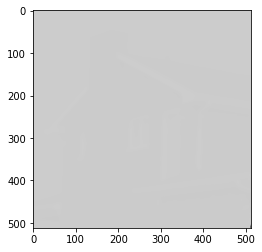

In [15]:
imshow(inhomold_3pt(c.copy(), .05, dt=0.01, Nt = 500, dx=1, dy=1))